<a href="https://colab.research.google.com/github/apandit42/cs229tings/blob/master/YY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Machine Learning Implementations

1. Sampling
1. Logistic Regression
1. Naive Bayes
1. K Means Clustering
1. Hierarchical Clustering
1. GDA
1. SVM / Kernel Methods

In [15]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pickle
import seaborn as sns
from sklearn import model_selection

# 1. Sampling Setup

In [16]:
db = pd.read_csv('fifa_final.csv')
RANDOM_SEED = 42069360
db.head()

,Unnamed: 0,id,fifa_year,name,first_name,last_name,ws_team_name,ws_tournament_name,ws_player_id,ws_season,age,height,weight,position,appearances,subs_on,min_played,goal_per_game,assists_total_per_game,yellow_cards_per_game,red_cards_per_game,shots_per_game,aerials_won_per_game,man_of_match_per_game,pass_success,tackles_per_game,interceptions_per_game,fouls_per_game,offsides_won_per_game,clearance_per_game,was_dribbled_per_game,outfielder_blocked_per_game,goal_own_per_game,key_pass_per_game,dribbles_won_per_game,fouls_given_per_game,offsides_given_per_game,dispossessed_per_game,turnovers_per_game,total_passes_per_game,accurate_crosses_per_game,accurate_long_passes_per_game,accurate_through_ball_per_game,fifa_pace,fifa_acceleration,fifa_sprint_speed,fifa_shooting,fifa_positioning,fifa_finishing,fifa_shot_power,fifa_long_shots,fifa_volleys,fifa_penalties,fifa_passing,fifa_vision,fifa_crossing,fifa_free_kick,fifa_short_passing,fifa_long_passing,fifa_curve,fifa_dribbling,fifa_agility,fifa_balance,fifa_reactions,fifa_ball_control,fifa_dribbling_min,fifa_composure,fifa_defense,fifa_marking,fifa_interceptions,fifa_heading_accuracy,fifa_standing_tackle,fifa_sliding_tackle,fifa_physical,fifa_jumping,fifa_stamina,fifa_strength,fifa_aggression,fifa_overall_score,fifa_overall_category
0,0,1,2021,Robert Lewandowski,Robert,Lewandowski,Bayern Munich,Bundesliga,29400,2019/2020,32,184,80,ST,41,0,3649,1.195122,0.219512,0.121951,0.000000,4.825806,2.416129,0.317073,75.885572,0.790323,0.212903,1.066129,0.016129,0.609677,0.593548,0.016129,0,1.630645,1.535484,1.493548,0.474194,1.470968,2.056452,24.770968,0.261290,0.491935,0.114516,78,77,78,91,94,94,89,85,89,88,78,79,71,85,84,70,79,86,77,82,93,88,85,88,43,35,49,85,42,19,82,84,76,86,81,91,gold
1,1,2,2021,Lionel Messi,Lionel,Messi,Barcelona,LaLiga,11119,2019/2020,33,170,72,RW,41,2,3542,0.682927,0.585366,0.146341,0.000000,4.346591,0.339015,0.634146,82.224473,0.443182,0.231061,0.678030,0.000000,0.015152,0.585227,0.000000,0,2.410985,6.320076,2.248106,0.259470,2.369318,1.857955,53.361742,0.596591,2.200758,0.568182,85,91,80,92,93,95,86,94,88,75,91,95,85,94,91,91,93,95,91,95,94,96,96,96,38,32,40,70,35,24,65,68,72,69,44,93,gold
2,2,3,2021,Neymar,Neymar da Silva,Santos Júnior,Paris Saint-Germain,Ligue 1,50835,2019/2020,28,175,68,LW,22,1,1907,0.727273,0.454545,0.227273,0.045455,4.080952,0.176190,0.454545,77.566742,0.900000,0.276190,1.109524,0.000000,0.000000,1.028571,0.000000,0,2.442857,6.071429,4.280952,0.247619,3.104762,4.576190,52.485714,0.685714,1.790476,0.647619,91,94,89,85,87,87,80,84,87,92,86,90,85,89,87,81,88,94,96,83,91,95,95,93,36,35,36,62,30,29,59,62,81,50,51,91,gold
3,3,4,2021,Harry Kane,Harry,Kane,Tottenham,Premier League,83532,2019/2020,27,188,89,ST,34,0,3040,0.705882,0.058824,0.147059,0.000000,3.696552,2.075862,0.176471,71.118574,0.610345,0.103448,1.037931,0.000000,0.917241,0.424138,0.120690,0,0.865517,1.282759,1.458621,0.644828,0.951724,1.872414,19.334483,0.168966,0.996552,0.186207,68,66,69,91,93,94,91,86,85,90,80,83,75,68,81,83,80,81,69,73,90,84,80,91,47,56,35,85,36,38,83,79,84,84,81,88,gold
4,4,5,2021,Toni Kroos,Toni,Kroos,Real Madrid,LaLiga,31772,2019/2020,30,183,76,CM,41,4,3196,0.121951,0.146341,0.073171,0.000000,1.980952,0.254762,0.073171,93.646575,2.050000,1.078571,0.816667,0.014286,0.352381,1.742857,0.000000,0,2.871429,1.011905,1.364286,0.111905,0.602381,0.895238,75.038095,1.402381,7.804762,0.097619,54,57,52,81,76,76,89,86,82,73,91,90,88,84,93,93,86,81,63,71,89,89,80,88,71,72,79,58,73,60,69,32,75,73,60,88,gold


In [17]:
# Feature Set for Predicting Card Level / Color
card_level_db = db[db.min_played >= 90].copy()

# Card Labels for Level / Color
card_labels = card_level_db[["fifa_overall_category", "fifa_overall_score", "fifa_physical", "fifa_defense", "fifa_dribbling", "fifa_passing", "fifa_shooting", "fifa_pace"]]

card_oscore_lb = card_labels.fifa_overall_score
card_physical_lb = card_labels.fifa_physical
card_defense_lb = card_labels.fifa_defense
card_dribbling_lb = card_labels.fifa_dribbling
card_passing_lb = card_labels.fifa_passing
card_shooting_lb = card_labels.fifa_shooting
card_pace_lb = card_labels.fifa_pace

card_labels = card_level_db.fifa_overall_category.map({'bronze': 0, 'silver': 1, 'gold': 2})

# Card Features for Level / Color
card_level_db = pd.concat([card_level_db.iloc[:, 7:40].drop(columns=['ws_season']), card_level_db.iloc[:, -1]], axis=1)
card_features = card_level_db.drop(columns=['fifa_overall_category'])
card_features = pd.get_dummies(card_features, drop_first=True, columns=['ws_tournament_name', 'position'])

# Splitting training and testing data, hard 80/20 Split
train_card_features, test_card_features, train_card_labels, test_card_labels = model_selection.train_test_split(card_features, card_labels, test_size=0.2, random_state=RANDOM_SEED)

# Card Groups for Level / Color, Training
train_card_features = train_card_features.drop(columns=['ws_player_id']).copy()

# Card Groups for Level / Color, Testing
test_card_features = test_card_features.drop(columns=['ws_player_id'])

# EVERYTHING ELSE FEATURES
overall_card_labels = pd.concat([card_oscore_lb, card_physical_lb, card_defense_lb, card_dribbling_lb, card_passing_lb, card_shooting_lb, card_pace_lb],axis=1)
train_2nd_card_features, test_2nd_card_features, train_2nd_card_labels, test_2nd_card_labels = model_selection.train_test_split(card_features, overall_card_labels, test_size=0.2, random_state=RANDOM_SEED)

display(train_2nd_card_labels)

train_2nd_card_features = train_2nd_card_features.drop(columns=['ws_player_id']).copy()
test_2nd_card_features = test_2nd_card_features.drop(columns=['ws_player_id']).copy()
# Initialization of each training label set
overall_train_labels = train_2nd_card_labels.fifa_overall_score
physical_train_labels = train_2nd_card_labels.fifa_physical
defense_train_labels = train_2nd_card_labels.fifa_defense
dribbling_train_labels = train_2nd_card_labels.fifa_dribbling
passing_train_labels = train_2nd_card_labels.fifa_passing
shooting_train_labels = train_2nd_card_labels.fifa_shooting
pace_train_labels = train_2nd_card_labels.fifa_pace

# Initialization of each testing label set
overall_test_labels = test_2nd_card_labels.fifa_overall_score
physical_test_labels = test_2nd_card_labels.fifa_physical
defense_test_labels = test_2nd_card_labels.fifa_defense
dribbling_test_labels = test_2nd_card_labels.fifa_dribbling
passing_test_labels = test_2nd_card_labels.fifa_passing
shooting_test_labels = test_2nd_card_labels.fifa_shooting
pace_test_labels = test_2nd_card_labels.fifa_pace

,fifa_overall_score,fifa_physical,fifa_defense,fifa_dribbling,fifa_passing,fifa_shooting,fifa_pace
10328,70,62,65,69,59,60,86
12781,65,72,37,58,52,63,54
6128,76,75,56,78,72,72,73
2147,71,74,56,72,67,68,68
14024,80,67,32,76,71,77,75
...,...,...,...,...,...,...,...
7914,70,74,30,68,61,64,84
16702,69,80,69,61,58,49,46
913,58,65,58,44,38,29,48
13705,78,72,71,79,76,67,77


# 2. Dataset Features

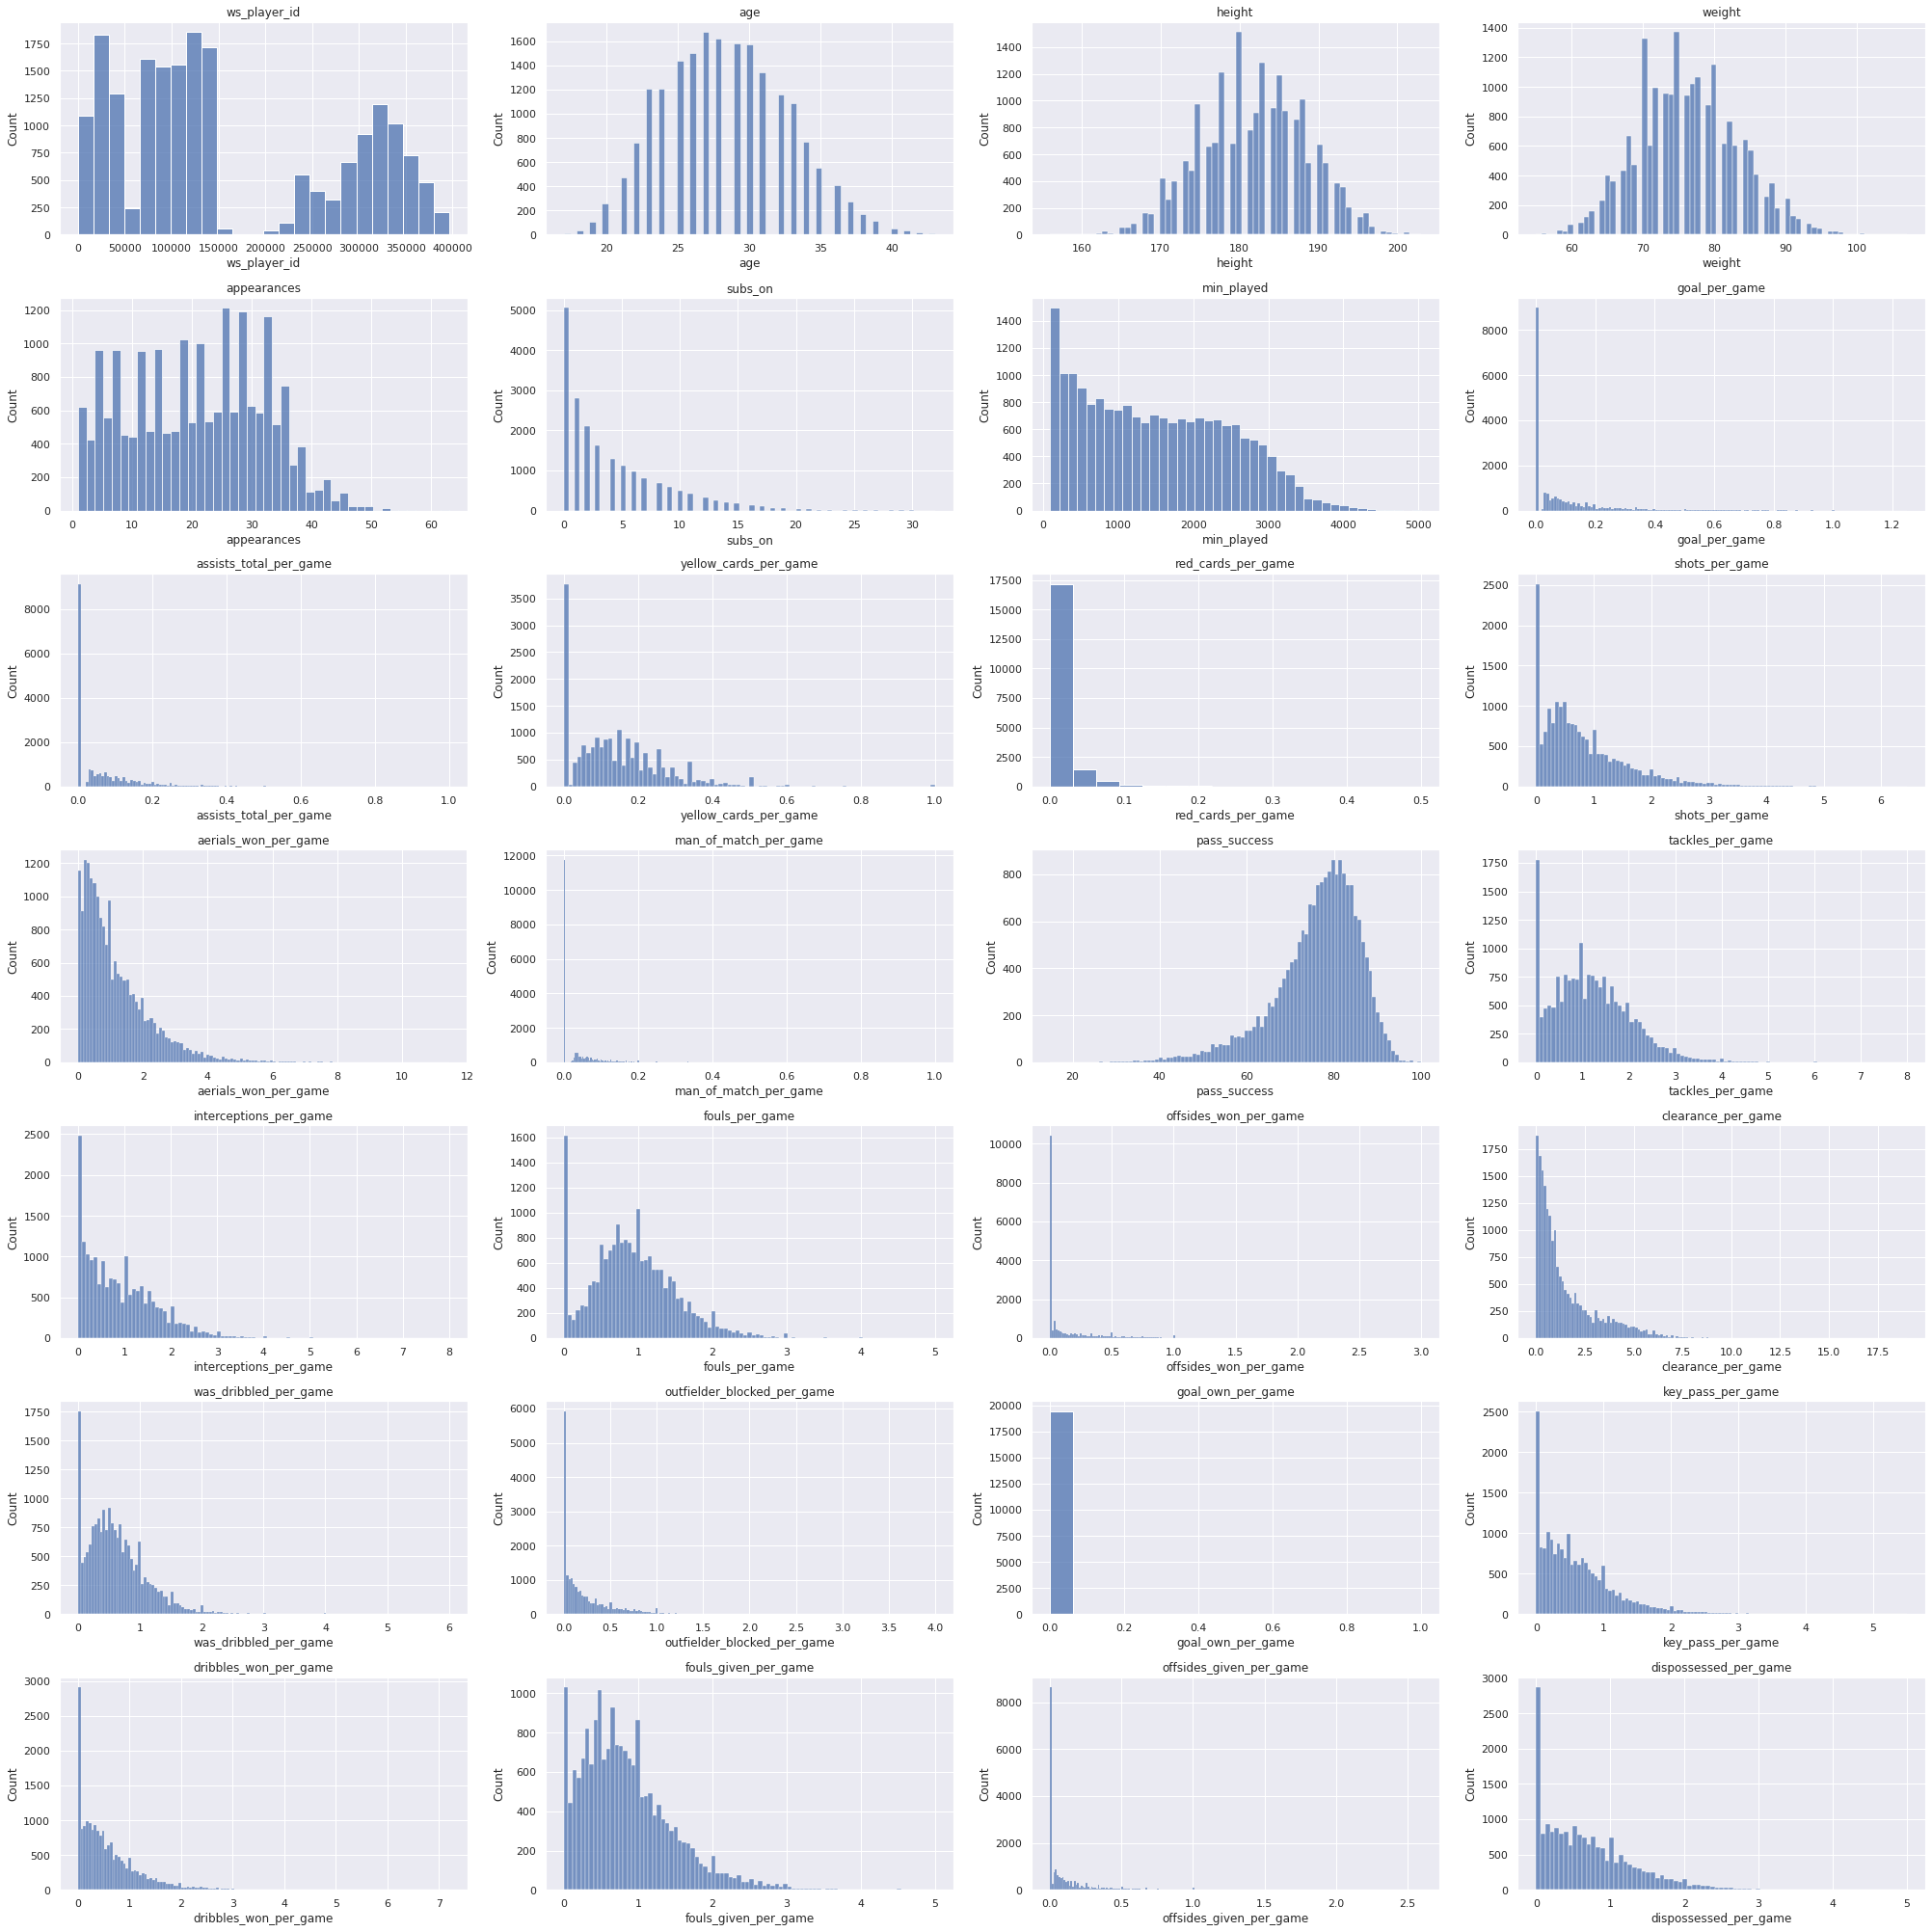

In [18]:
# Graphing Data Points
sns.set_theme("notebook")

num_features = 28
fig, ax = plt.subplots(7, 4, figsize=(28,28))
iter = 0
for i in range(7):
  for j in range(4):
    sns.histplot(card_features.iloc[:, iter], ax = ax[i, j])
    ax[i,j].set_title(card_features.columns.to_list()[iter])
    iter += 1
fig.tight_layout()


## Best Feature Analysis 

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

def bestFeaturePlot(top_features, X, savepath):
  # plots distributions of n best features
  n = len(top_features)
  fig, axs = plt.subplots(n//2, n - n//2, figsize=(6, 6))
  iter_0 = 0 
  iter_1 = 0
  for j in range(n):
    index = top_features[j]
    feature = X[X.iloc[:,index]>0]
    feature = feature.iloc[:, index]
    sns.histplot(feature, ax = axs[iter_0, iter_1])
    axs[iter_0, iter_1].set_title(X.columns.to_list()[index])
    iter_0 += 1
    if iter_0 == n//2:
      iter_0 = 0
      iter_1 += 1
  plt.tight_layout()
  plt.savefig(savepath)


"""Must pass in the ML modelm, the number of features you want to determine,
the method of calculation of those best features, the training data with binary
features removed, and the corresponding labels."""
def bestFeatureSelect(num_features, clf, train_data, labels, method = "all"):
  if method == "all":
    selection = RFE(clf, num_features)
    selector = selection.fit(train_data, labels)     # fit data using clf
    top_features = selector.get_support(True)
    print(f"REF: {top_features}")
    bestFeaturePlot(top_features, train_data, "best_feat_RFE.png")

    X_best = SelectKBest(chi2, k=num_features).fit(train_data, labels)
    top_features = X_best.get_support(True)
    print(f"K best: {top_features}")
    bestFeaturePlot(top_features, X, "K_best_feat.png")

    L1_best_feat = SelectFromModel(clf, max_features = num_features)
    L1_best_feat = L1_best_feat.fit(train_data, labels)
    top_features = L1_best_feat.get_support(True)
    print(f"L1 best feat: {top_features}")
    bestFeaturePlot(top_features, X, "L1_best_feat.png")

  elif method == "REF":
    # # Recursive Feature Elimination Method
    selection = RFE(clf, num_features)
    selector = selection.fit(train_data, labels)     # fit data using clf
    top_features = selector.get_support(True)            # gets indices of top features
    print(f"REF: {top_features}")
    bestFeaturePlot(top_features, X)

  elif method == "KBest":
    # # Best K Features Method
    X_best = SelectKBest(chi2, k=num_features).fit(train_data, labels)
    top_features = X_best.get_support(True)
    print(f"K best: {top_features}")
    bestFeaturePlot(top_features, X)

  elif method == "L1Select":
    # L1 Based Feature Selection
    L1_best_feat = SelectFromModel(clf, max_features = n)
    L1_best_feat = L1_best_feat.fit(train_data, labels)
    top_features = L1_best_feat.get_support(True)
    print(f"L1 best feat: {top_features}")
    bestFeaturePlot(top_features, X)


# # Removing binary labels from data
X = train_data.loc[:, : "total_passes_per_game"]
y = train_card_labels
# # Finding 4 best features for logistic regression
n = 4 
clf = LogisticRegression(solver="newton-cg", class_weight="balanced", max_iter=100000)
bestFeatureSelect(4, clf, X, y)

# 3. Card Color Prediction Benchmarking

In [19]:
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import dummy
from sklearn import tree
from sklearn import discriminant_analysis
from sklearn import svm
from sklearn import preprocessing
from imblearn import under_sampling
from imblearn import over_sampling
from imblearn import combine as combine_sampling
from sklearn import ensemble
from sklearn import neural_network
from sklearn import gaussian_process

## Color Classification Model 

In [28]:
class ValidatorWrapper():  
  def __init__(self, train_features, train_labels, test_features, test_labels):
    self.x_test = test_features.copy()
    self.y_test = test_labels.copy()
    self.fig_size = (5, 4)

In [23]:
class ColorModelValidator(ValidatorWrapper):
  def __init__(self, train_features, train_labels, test_features, test_labels):
    super().__init__(train_features, train_labels, test_features, test_labels)
    self.x, self.y = self.rescale_classes(train_features.copy(), train_labels.copy())

    self.model_balanced_accuracies = []
    self.model_accuracies = []        

    self.func_prob_a = set(['GaussianProcess','GradientBoost','RandomForest','QDA','MLP','LogisticRegressionOVR','BernoulliNB','Dummy', 'GaussianNB', 'LogisticRegression', 'DecisionTree', 'KNN', 'LDA', 'ExtraTreeClassifier', 'ExtraTreesClassifier'])
    self.convert_probs_set = set(['Ridge', 'LinearSVC', 'SVM-SVC'])
  
  def rescale_classes(self, x, y):
    sampler = over_sampling.SMOTE(sampling_strategy='all')
    sampler = combine_sampling.SMOTETomek(smote=sampler, sampling_strategy='all')
    x, y = sampler.fit_resample(x, y)
    x = pd.DataFrame(x)
    y = pd.Series(y)
    return x, y
  
  def model_stats(self, name, clf):
    x = self.x
    y = self.y

    clf.fit(x, y)
    yp = clf.predict(self.x_test)

    if name in self.func_prob_a:
      y_prob = clf.predict_proba(self.x_test)
    else:
      y_prob = clf.decision_function(self.x_test)
    if name in self.convert_probs_set:
      y_prob = np.exp(y_prob) / np.sum(np.exp(y_prob), axis=1)[:,None]
    y_prob = pd.DataFrame(y_prob)
    yp = pd.DataFrame(yp)

    plt.figure(figsize=self.fig_size)
    for i in range(y_prob.shape[1]):
      fp, tp, thr = metrics.roc_curve(self.y_test, y_prob.iloc[:,i], pos_label=i)
      sns.lineplot(x=fp, y=tp, ci=None, estimator=None)
    plt.legend()        ### OUTPUT SAYS NO LABELS FOUND
    plt.title(f'{name} ROC Curve')
    plt.ylabel('TP Rate')
    plt.xlabel('FP Rate')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=self.fig_size)
    for i in range(y_prob.shape[1]):
      pr, rc, thr = metrics.precision_recall_curve(self.y_test, y_prob.iloc[:,i], pos_label=i)
      sns.lineplot(x=rc, y=pr, ci=None, estimator=None)
    plt.legend()        ### OUTPUT SAYS NO LABELS FOUND
    plt.title(f'{name} Precision Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=self.fig_size)
    confusion_matrix = metrics.confusion_matrix(self.y_test, yp, normalize='all')
    sns.heatmap(confusion_matrix, annot=True).set_title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Pre-plotting functions
    self.model_balanced_accuracies.append(metrics.balanced_accuracy_score(self.y_test, yp))
    target_names = ["bronze", "silver", "gold"]
    report = metrics.classification_report(self.y_test, yp, 
                                              target_names=target_names, output_dict=True)
    report = metrics.classification_report(self.y_test, yp, target_names=target_names, output_dict=True)
    print(metrics.classification_report(self.y_test, yp, target_names=target_names))
    target_accuracies = []        # creates list of precisions
    for target_name in target_names:
      class_report = report[target_name]         # gets report for particular class
      # print(class_report)
      target_accuracies.append(class_report['precision'])
    self.model_accuracies.append(target_accuracies) 
  
  def player_color_rank(self, to_run=None):
    accuracies = []
    models = []
    
    if to_run is None or "gdc" in to_run:
      gdc = ensemble.GradientBoostingClassifier(init=linear_model.LogisticRegression(solver="newton-cg",class_weight="balanced"))
      self.model_stats("GradientBoost", gdc)
      models.append("GradientBoost")

    if to_run is None or "rdf" in to_run:
      rdf = ensemble.RandomForestClassifier(criterion="entropy",n_jobs=-1, class_weight="balanced")
      self.model_stats("RandomForest", rdf)
      models.append("RDF")

    if to_run is None or "qda" in to_run:
      qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
      self.model_stats("QDA", qda)
      models.append("QDA")
      
    if to_run is None or "bnb" in to_run:
      bern_nb = naive_bayes.BernoulliNB()
      self.model_stats("BernoulliNB", bern_nb)
      models.append("Bernoulli Naive Bayes")
    
    if to_run is None or "etc" in to_run:
      etc = tree.ExtraTreeClassifier(criterion="entropy", class_weight="balanced")
      self.model_stats("ExtraTreeClassifier", etc)
      models.append("Extra Tree Classifier")

    if to_run is None or "etc_b" in to_run:
      etc_b = ensemble.ExtraTreesClassifier(criterion="entropy", n_jobs=-1, class_weight="balanced")
      self.model_stats("ExtraTreesClassifier", etc_b)
      models.append("ExtraTreesClassifier")

    if to_run is None or "gnb" in to_run:
      gauss_nb = naive_bayes.GaussianNB()
      self.model_stats("GaussianNB", gauss_nb)
      models.append("Gaussian Naïve Bayes")

    if to_run is None or "logreg" in to_run:
      logregcv = linear_model.LogisticRegression(solver="newton-cg", class_weight="balanced", multi_class='ovr', n_jobs=-1, max_iter=10000)
      self.model_stats("LogisticRegressionOVR", logregcv)
      models.append("Logistic Regression OVR")  

    if to_run is None or "logreg" in to_run:
      logreg = linear_model.LogisticRegression(solver="newton-cg", class_weight="balanced", multi_class="multinomial", n_jobs=-1, max_iter=10000)  
      self.model_stats("LogisticRegression", logreg)
      models.append("Logistic Regression Multinomial")

    if to_run is None or "dectree" in to_run:
      dectree = tree.DecisionTreeClassifier(criterion="entropy", class_weight="balanced")
      self.model_stats("DecisionTree", dectree)
      models.append("Decision Tree")

    if to_run is None or "lda" in to_run:
      lda = discriminant_analysis.LinearDiscriminantAnalysis()
      self.model_stats("LDA", lda)
      models.append("LDA")

    if to_run is None or "ridge" in to_run:
      ridge = linear_model.RidgeClassifier(normalize=True)
      self.model_stats("Ridge", ridge)
      models.append("Ridge Classifier")
    ### CODE DOES NOT RUN ### 
    # if to_run is None or "svm_svc" in to_run:
    #   svc = svm.SVC(kernel='sigmoid', probability=True, decision_function_shape='ovr')
    #   self.model_stats("SVM-SVC", svc)
    #   models.append("SVM Classifier")

    # if to_run is None or "linear_svc" in to_run:
    #   linear_svc = svm.LinearSVC()
    #   self.model_stats('LinearSVC', linear_svc)
    #   models.append("LinearSVC")

    # # Plotting
    fig, ax = plt.subplots(figsize = (16,6))  # subplots of bar graphs
    precisions = self.model_accuracies
    balanced_acc = self.model_balanced_accuracies   
    n = len(models)       # nunmber of models ran
    colors = sns.color_palette('flare')
    idx = [0, 1.5, 3, 4.5]      # indices of four plotted stats
    space = 0.5         # space between models' bars
    bar_width = 0.5       # width of bar

    for i in range(n):
      precisions[i].append(balanced_acc[i])
      x = precisions[i]
      if i > 0:
        idx = [index + space for index in idx]
      ax.bar(idx, x, color = sns.color_palette("colorblind")[i], width=bar_width)     # plot for current model
      idx = [index + 4 for index in idx]    # update indices
    ax.set_xticks([0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, 15, 16.5, 18, 19.5, 21, 22.5, 24])               # sets ticks
    ax.set_xticklabels(["Bronze Prec.", "Silver Prec.", "Gold Prec.", "Balanced Accuracy"] * n, rotation=65)
    ax.legend(models[:n], loc=[1, 0.8])
    plt.title("Accuracy/Precisions of each Model")
    plt.ylabel("Accuracy/Precision")
    plt.savefig("Color_Models_Accuracies.png")

    plt.show()

## Overall Model Classifier

In [38]:
class OverallModelValidator(ValidatorWrapper):

  def __init__(self, train_features, train_labels, test_features, test_labels):
    super().__init__(train_features, train_labels, test_features, test_labels)
    
    self.x, self.y = pd.concat([train_features.copy(),train_features.copy(),train_features.copy()],axis=0), pd.concat([train_labels.copy(),train_labels.copy(),train_labels.copy()],axis=0)
    
    self.x_test = pd.concat([test_features.copy(),test_features.copy(),test_features.copy()],axis=0)
    self.y_test = pd.concat([test_labels.copy(),test_labels.copy(),test_labels.copy()],axis=0)

    self.func_prob_a = set(['GaussianProcess','GradientBoost','RandomForest','QDA','MLP','LogisticRegressionOVR','BernoulliNB','Dummy', 'GaussianNB', 'LogisticRegression', 'DecisionTree', 'KNN', 'LDA', 'ExtraTreeClassifier', 'ExtraTreesClassifier'])
    self.convert_probs_set = set(['Ridge', 'LinearSVC', 'SVM-SVC'])
  
  def light_stats(self, name, clf):
    x = self.x
    y = self.y
    clf.fit(x, y)
    yp = clf.predict(self.x_test)

    if name in self.func_prob_a:
      y_prob = clf.predict_proba(self.x_test)
    else:
      y_prob = clf.decision_function(self.x_test)
    if name in self.convert_probs_set:
      y_prob = np.exp(y_prob) / np.sum(np.exp(y_prob), axis=1)[:,None]
    y_prob = pd.DataFrame(y_prob)
    yp = pd.DataFrame(yp)

    print(f"{name} Model Report (Avg):")
    print(metrics.classification_report(self.y_test, yp))
    print(f"{name} Balanced Accuracy: {metrics.balanced_accuracy_score(self.y_test, yp)}")
    print(f"{name} ROC AUC Values: {metrics.roc_auc_score(self.y_test, y_prob, multi_class='ovr', average='weighted')}")
    
    plt.figure()
    for i in range(y_prob.shape[1]):
      fp, tp, thr = metrics.roc_curve(self.y_test, y_prob.iloc[:,i], pos_label=i)
      sns.lineplot(x=fp, y=tp, ci=None, estimator=None)
    plt.legend()
    plt.title(f'{name} ROC Curve')
    plt.ylabel('TP Rate')
    plt.xlabel('FP Rate')
    plt.tight_layout()
    plt.show()

    plt.figure()
    for i in range(y_prob.shape[1]):
      pr, rc, thr = metrics.precision_recall_curve(self.y_test, y_prob.iloc[:,i], pos_label=i)
      sns.lineplot(x=rc, y=pr, ci=None, estimator=None)
    plt.legend()
    plt.title(f'{name} Precision Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.tight_layout()
    plt.show()
  
  def player_overall_rank(self, to_run=None):
    if to_run is None or "rdf" in to_run:
      rdf = ensemble.RandomForestClassifier(criterion="entropy",n_jobs=-1, class_weight="balanced")
      self.light_stats("RandomForest", rdf)

    if to_run is None or "bnb" in to_run:
      bern_nb = naive_bayes.BernoulliNB()
      self.light_stats("BernoulliNB", bern_nb)

    if to_run is None or "gnb" in to_run:
      gauss_nb = naive_bayes.GaussianNB()
      self.light_stats("GaussianNB", gauss_nb)

    if to_run is None or "logreg" in to_run:
      logregcv = linear_model.LogisticRegression(solver="newton-cg", class_weight="balanced", multi_class='ovr', n_jobs=-1, max_iter=10000)
      self.light_stats("LogisticRegressionOVR", logregcv)

    if to_run is None or "logreg" in to_run:
      logreg = linear_model.LogisticRegression(solver="newton-cg", class_weight="balanced", multi_class="multinomial", n_jobs=-1, max_iter=10000)  
      self.light_stats("LogisticRegression", logreg)

    if to_run is None or "lda" in to_run:
      lda = discriminant_analysis.LinearDiscriminantAnalysis()
      self.light_stats("LDA", lda)

    if to_run is None or "ridge" in to_run:
      ridge = linear_model.RidgeClassifier(normalize=True)
      self.light_stats("Ridge", ridge)

    if to_run is None or "svm_svc" in to_run:
      svc = svm.SVC(kernel='sigmoid', probability=True, decision_function_shape='ovr')
      self.light_stats("SVM-SVC", svc)

## OVERALL

In [41]:
dungus = OverallModelValidator(train_2nd_card_features, overall_train_labels, test_2nd_card_features, overall_test_labels)
dungus.player_overall_rank()

RandomForest Model Report (Avg):
              precision    recall  f1-score   support

          49       0.00      0.00      0.00         3
          50       0.00      0.00      0.00         6
          51       0.00      0.00      0.00         6
          53       0.00      0.00      0.00        12
          54       0.00      0.00      0.00        15
          55       0.00      0.00      0.00        24
          56       0.00      0.00      0.00        27
          57       0.00      0.00      0.00        30
          58       0.00      0.00      0.00        39
          59       0.15      0.12      0.13        51
          60       0.08      0.08      0.08        78
          61       0.08      0.04      0.05       159
          62       0.07      0.09      0.08       102
          63       0.14      0.11      0.12       213
          64       0.13      0.11      0.12       321
          65       0.04      0.03      0.04       372
          66       0.07      0.05      0.06     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


ValueError: ignored

## Color Classification Model Benchmarking 2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/s

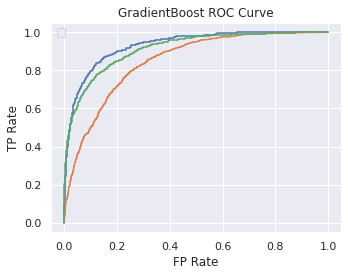

No handles with labels found to put in legend.


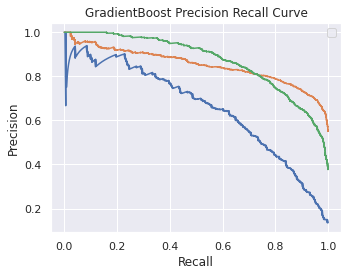

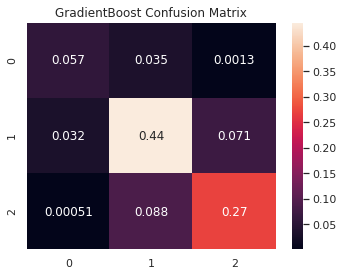

{'precision': 0.6379310344827587, 'recall': 0.6132596685082873, 'f1-score': 0.6253521126760563, 'support': 362}
{'precision': 0.7837715321849501, 'recall': 0.8121183654297792, 'f1-score': 0.7976931949250288, 'support': 2129}
{'precision': 0.7893553223388305, 'recall': 0.7537580529706513, 'f1-score': 0.7711461003295496, 'support': 1397}


No handles with labels found to put in legend.


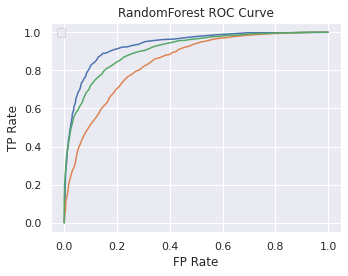

No handles with labels found to put in legend.


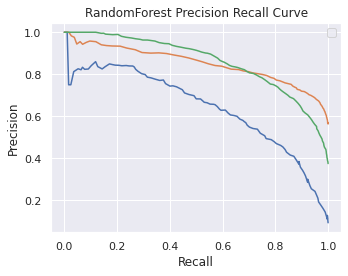

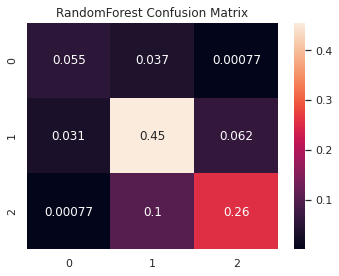

{'precision': 0.6342182890855457, 'recall': 0.5939226519337016, 'f1-score': 0.6134094151212554, 'support': 362}
{'precision': 0.7653679653679654, 'recall': 0.8304368248003757, 'f1-score': 0.7965758053615678, 'support': 2129}
{'precision': 0.8038740920096852, 'recall': 0.7129563350035791, 'f1-score': 0.755690440060698, 'support': 1397}


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
No handles with labels found to put in legend.


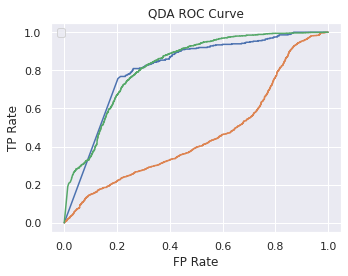

No handles with labels found to put in legend.


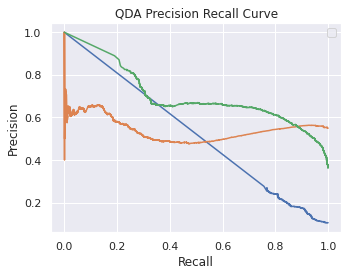

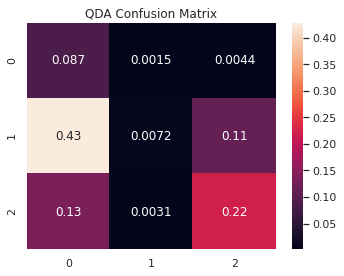

No handles with labels found to put in legend.


{'precision': 0.13436385255648037, 'recall': 0.93646408839779, 'f1-score': 0.23500866551126512, 'support': 362}
{'precision': 0.6086956521739131, 'recall': 0.013151714419915453, 'f1-score': 0.02574712643678161, 'support': 2129}
{'precision': 0.6557998483699773, 'recall': 0.6191839656406586, 'f1-score': 0.6369661266568483, 'support': 1397}


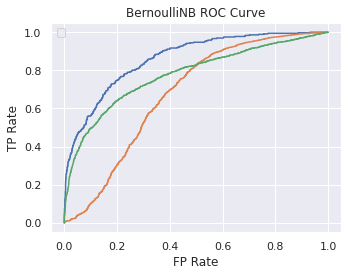

No handles with labels found to put in legend.


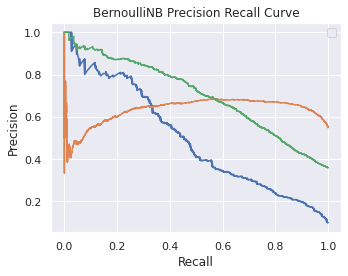

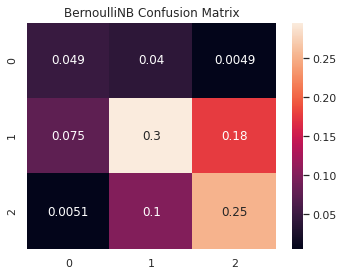

No handles with labels found to put in legend.


{'precision': 0.37649402390438247, 'recall': 0.5220994475138122, 'f1-score': 0.43750000000000006, 'support': 362}
{'precision': 0.6778761061946903, 'recall': 0.5396899953029591, 'f1-score': 0.6009414225941423, 'support': 2129}
{'precision': 0.5824955647545831, 'recall': 0.7050823192555477, 'f1-score': 0.6379533678756477, 'support': 1397}


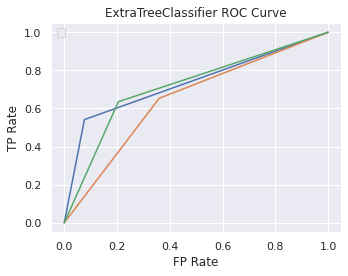

No handles with labels found to put in legend.


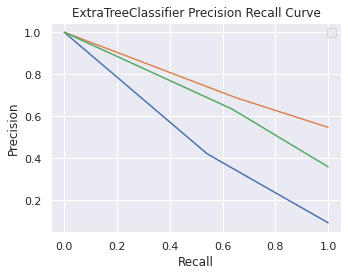

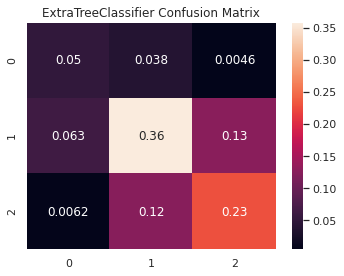

{'precision': 0.421505376344086, 'recall': 0.5414364640883977, 'f1-score': 0.4740024183796856, 'support': 362}
{'precision': 0.6872529644268774, 'recall': 0.6533583842179427, 'f1-score': 0.6698771972068384, 'support': 2129}
{'precision': 0.6347390993566834, 'recall': 0.635647816750179, 'f1-score': 0.6351931330472104, 'support': 1397}


No handles with labels found to put in legend.


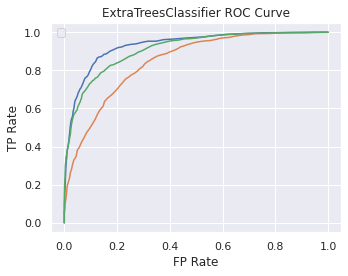

No handles with labels found to put in legend.


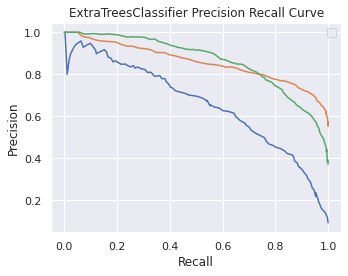

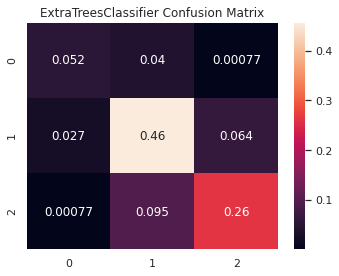

No handles with labels found to put in legend.


{'precision': 0.6527331189710611, 'recall': 0.5607734806629834, 'f1-score': 0.6032689450222883, 'support': 362}
{'precision': 0.7713043478260869, 'recall': 0.833255049318929, 'f1-score': 0.8010837660871527, 'support': 2129}
{'precision': 0.8018794048551292, 'recall': 0.7329992841803865, 'f1-score': 0.7658937920718025, 'support': 1397}


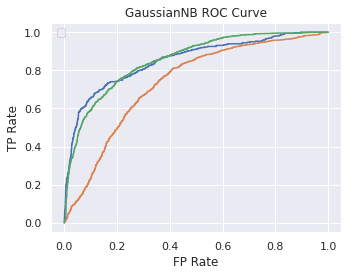

No handles with labels found to put in legend.


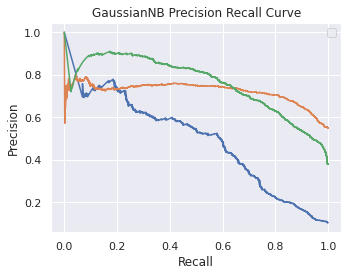

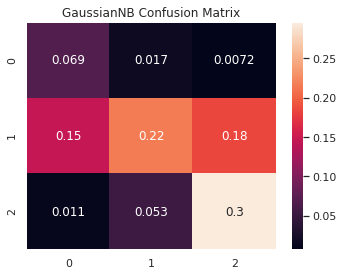

{'precision': 0.3037542662116041, 'recall': 0.7375690607734806, 'f1-score': 0.43029814665592264, 'support': 362}
{'precision': 0.7551569506726458, 'recall': 0.3954908407703147, 'f1-score': 0.5191122071516646, 'support': 2129}
{'precision': 0.6066525871172123, 'recall': 0.8224767358625626, 'f1-score': 0.698268003646308, 'support': 1397}


No handles with labels found to put in legend.


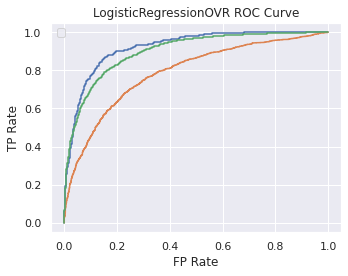

No handles with labels found to put in legend.


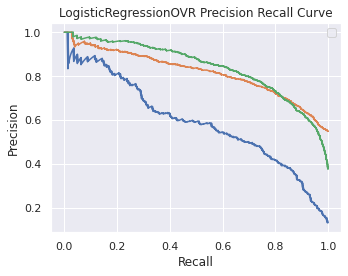

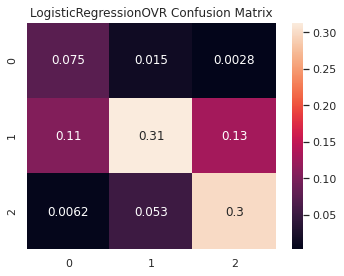

{'precision': 0.4016506189821183, 'recall': 0.8066298342541437, 'f1-score': 0.5362718089990817, 'support': 362}
{'precision': 0.8200808625336927, 'recall': 0.5716298731798967, 'f1-score': 0.6736783836147245, 'support': 2129}
{'precision': 0.6946929039952295, 'recall': 0.8339298496778812, 'f1-score': 0.7579700715679896, 'support': 1397}


No handles with labels found to put in legend.


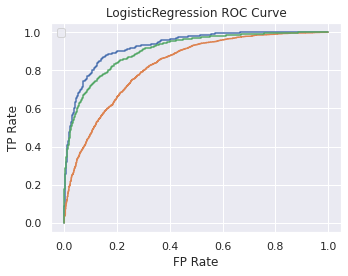

No handles with labels found to put in legend.


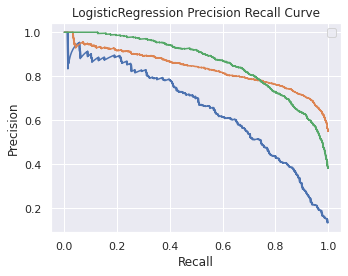

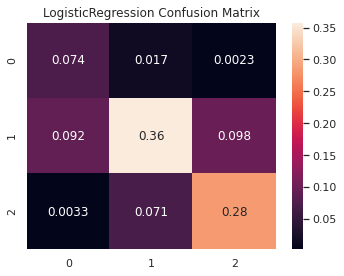

{'precision': 0.4368340943683409, 'recall': 0.7928176795580111, 'f1-score': 0.5632973503434741, 'support': 362}
{'precision': 0.8020773225620311, 'recall': 0.6528886801315171, 'f1-score': 0.7198342827550491, 'support': 2129}
{'precision': 0.7389853137516689, 'recall': 0.7924123120973514, 'f1-score': 0.7647668393782382, 'support': 1397}


No handles with labels found to put in legend.


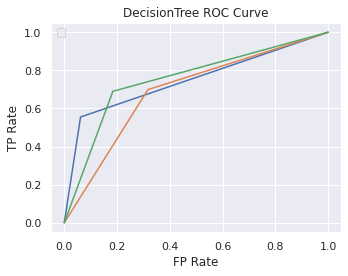

No handles with labels found to put in legend.


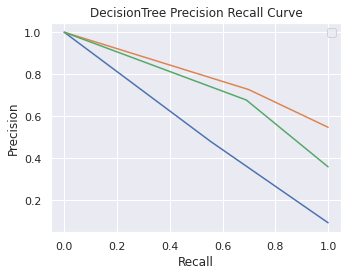

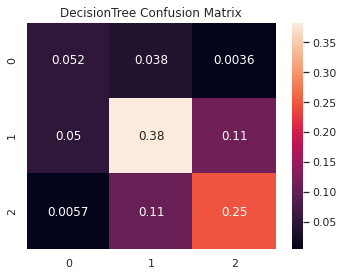

{'precision': 0.4797136038186158, 'recall': 0.5552486187845304, 'f1-score': 0.5147247119078106, 'support': 362}
{'precision': 0.7272727272727273, 'recall': 0.6989196806012212, 'f1-score': 0.712814371257485, 'support': 2129}
{'precision': 0.6774420238931834, 'recall': 0.690050107372942, 'f1-score': 0.6836879432624114, 'support': 1397}


No handles with labels found to put in legend.


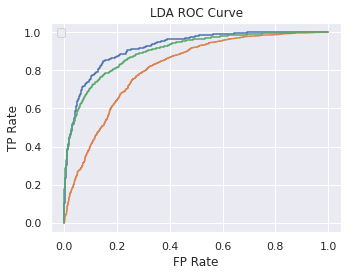

No handles with labels found to put in legend.


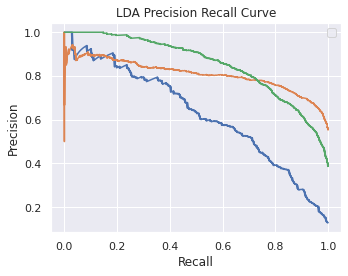

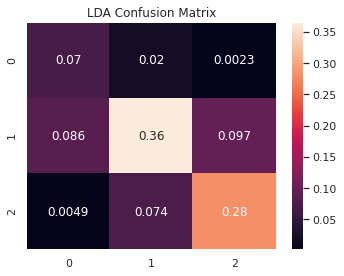

No handles with labels found to put in legend.


{'precision': 0.4370015948963317, 'recall': 0.7569060773480663, 'f1-score': 0.5540950455005055, 'support': 362}
{'precision': 0.793952967525196, 'recall': 0.6660403945514326, 'f1-score': 0.7243933588761174, 'support': 2129}
{'precision': 0.7383050847457627, 'recall': 0.7795275590551181, 'f1-score': 0.7583565459610027, 'support': 1397}


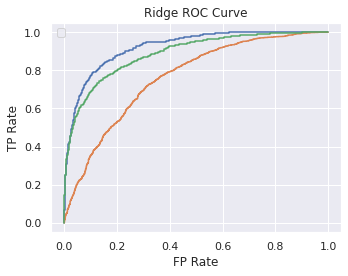

No handles with labels found to put in legend.


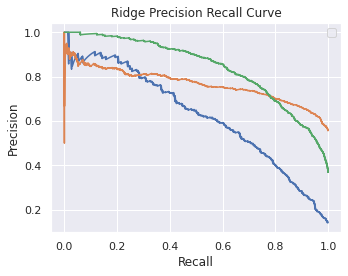

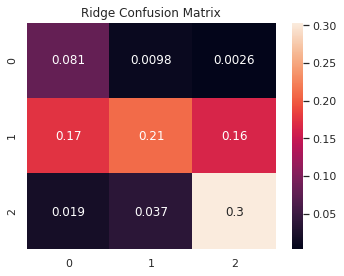

{'precision': 0.2945590994371482, 'recall': 0.8674033149171271, 'f1-score': 0.43977591036414565, 'support': 362}
{'precision': 0.8172690763052208, 'recall': 0.38233912635039924, 'f1-score': 0.52096, 'support': 2129}
{'precision': 0.6456736035049289, 'recall': 0.8439513242662849, 'f1-score': 0.7316165063605338, 'support': 1397}


IndexError: ignored

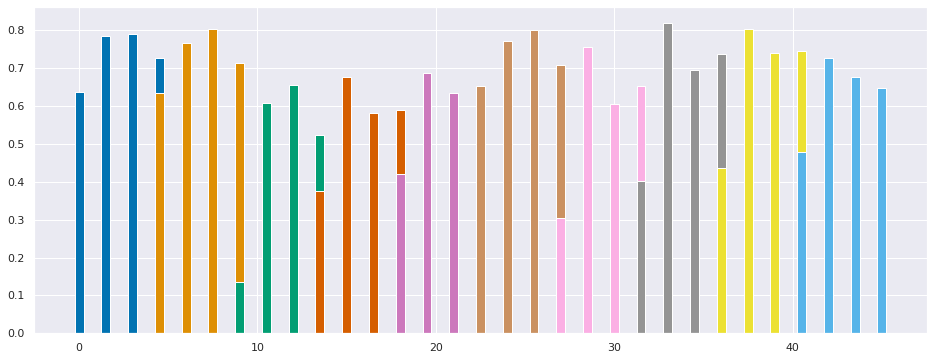

In [26]:
chungus = ColorModelValidator(train_card_features, train_card_labels, test_card_features, test_card_labels)
chungus.player_color_rank()

## Card Overall Regression

In [55]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import kernel_ridge
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

"""Function the plots multiple regression metrics for a given model."""
def regressionMetric(y_truth, y_predic, bar_width = 0.8, model_name = "Jungus"):
  var_score = metrics.explained_variance_score(y_truth, y_predic)       # explained variance score
  RMSE = metrics.mean_squared_error(y_truth, y_predic, squared=False)             # root means squared error
  print(f"RMSE: {RMSE}")
  max_error = metrics.max_error(y_truth, y_predic)                  # max error of model
  print(f"Max Error: {max_error}")
  MAB = metrics.mean_absolute_error(y_truth, y_predic)              # mean absolute error
  MSElog = metrics.mean_squared_log_error(y_truth, y_predic)        # means squared log error
  # r2 scores averaged with variance weight
  var_weighted_r2 = metrics.r2_score(y_truth, y_predic, multioutput='variance_weighted')
  print(f"R^2: {var_weighted_r2}")     # can also output uniform average/raw scores
  poisson_deviance = metrics.mean_tweedie_deviance(y_truth, y_predic, power=1)         # avg poisson deviance
  gamma_deviance = metrics.mean_tweedie_deviance(y_truth, y_predic, power=2)          # avg gamma deviance
  fig = plt.figure()
  ax = fig.add_subplot(111)
  y = [var_score, RMSE, max_error, MAB, MSElog, var_weighted_r2, poisson_deviance, gamma_deviance]
  x = [i for i in range(len(y))]
  plt.bar(x, y, width=bar_width)
  ax.axhline(0, color="black")
  plt.title(f"Regression Metrics of Model: {model_name}")
  plt.xticks(np.arange(len(y)), ["Explained Var", "RMSE", "Max Error", "Mean Abs Error", "log MSE", "VR2", "Poi Deviance", "Gamma Deviance"], rotation=65)
  plt.ylabel("Score")
  plt.show()

class OverallRegressionModelValidator(ValidatorWrapper):
  def __init__(self, train_features, train_labels, test_features, test_labels):
    super().__init__(train_features, train_labels, test_features, test_labels)
    # training data init
    self.x_train, self.y_train = (train_features.copy(), train_labels.copy())
    # test data init
    self.x_test = test_features.copy()
    self.y_test = test_labels.copy()
    # list of all models
    self.models = ['KNeighbors','Tweedie','Gamma','Poisson','SGDRegressor','RidgeRegressr','GradientBoostingRegressor','BaggingRegressor', 'AdaBoostRegressor', 'KernelRidge', 'PLSRegression', "Linear Regression"]
  
  def light_stats(self, name, clf):
    yp = clf.predict(self.x_test)
    yp = pd.DataFrame(yp)
    print(name)
    regressionMetric(self.y_test, yp, model_name = name)
  
  def bungus(self):
    clf_fit = ensemble.HistGradientBoostingRegressor()
    clf_fit.fit(self.x_train, self.y_train)
    self.light_stats("Hist", clf_fit)
  
    clf_fit = ensemble.BaggingRegressor()
    clf_fit.fit(self.x_train, self.y_train)
    self.light_stats("Bagging", clf_fit)

    clf_fit = ensemble.AdaBoostRegressor()
    clf_fit.fit(self.x_train, self.y_train)
    self.light_stats("Ada", clf_fit)


Hist
RMSE: 3.1317361745831107
Max Error: 16.04928220867548
R^2: 0.7290274419313025


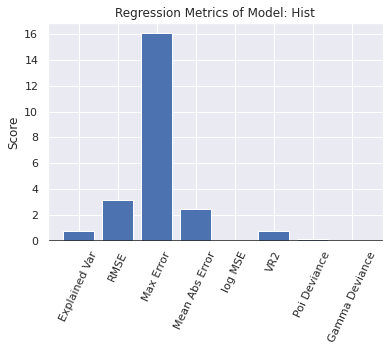

Bagging
RMSE: 3.456890223969533
Max Error: 15.599999999999994
R^2: 0.6698387117951811


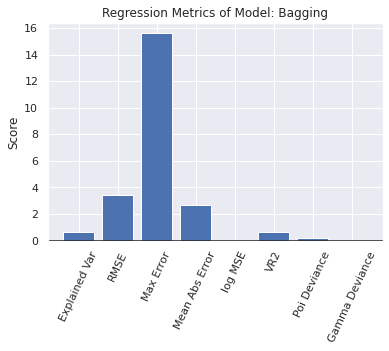

Ada
RMSE: 4.312827896919867
Max Error: 16.02961321514907
R^2: 0.4860992760085346


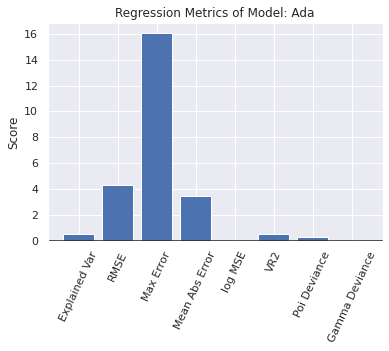

In [56]:
tgg = OverallRegressionModelValidator(train_2nd_card_features, overall_train_labels, test_2nd_card_features, overall_test_labels)
tgg.bungus()

# 4. Card Rank Classifier Benchmarking

## a. Overall Card Rank

In [ ]:
bungus = OverallModelValidator(train_2nd_card_features, overall_train_labels, test_2nd_card_features, overall_test_labels)
bungus.player_overall_rank()

## b. Pace Stat Rank

In [ ]:
bungus = OverallModelValidator(train_2nd_card_features, pace_train_labels, test_2nd_card_features, pace_test_labels)
bungus.player_overall_rank()

## c. Shooting Stat Rank

In [ ]:
bungus = OverallModelValidator(train_2nd_card_features, shooting_train_labels, test_2nd_card_features, shooting_test_labels)
bungus.player_overall_rank()

## d. Passing Stat Rank

In [ ]:
bungus = OverallModelValidator(train_2nd_card_features, passing_train_labels, test_2nd_card_features, passing_test_labels)
bungus.player_overall_rank()

## e. Dribbing Stat Rank

In [ ]:
bungus = OverallModelValidator(train_2nd_card_features, dribbling_train_labels, test_2nd_card_features, dribbling_test_labels)
bungus.player_overall_rank()

## f. Physical Stat Rank

In [ ]:
bungus = OverallModelValidator(train_2nd_card_features, physical_train_labels, test_2nd_card_features, physical_test_labels)
bungus.player_overall_rank()

# Card Rank Regression Benchmarking

### Overall Card Rank

In [ ]:
bungus = OverallRegressionModelValidator(train_2nd_card_features, overall_train_labels, test_2nd_card_features, overall_test_labels)
bungus.player_overall_rank()